In [1]:
import pickle
import matplotlib.pyplot as plt

import os
import zipfile
import numpy as np
import pandas as pd

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class TimeBlock(nn.Module):
    """
    Neural modelwork block that applies a temporal convolution to each node of
    a graph in isolation.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3):
        """
        :param in_channels: Number of input features at each node in each time
        step.
        :param out_channels: Desired number of output channels at each node in
        each time step.
        :param kernel_size: Size of the 1D temporal kernel.
        """
        super(TimeBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels)
        :return: Output data of shape (batch_size, num_nodes,
        num_timesteps_out, num_features_out=out_channels)
        """
        # Convert into NCHW format for pytorch to perform convolutions.
        X = X.permute(0, 3, 1, 2)
        temp = self.conv1(X) + torch.sigmoid(self.conv2(X))
        out = F.relu(temp + self.conv3(X))
        # Convert back from NCHW to NHWC
        out = out.permute(0, 2, 3, 1)
        return out


class STGCNBlock(nn.Module):
    """
    Neural modelwork block that applies a temporal convolution on each node in
    isolation, followed by a graph convolution, followed by another temporal
    convolution on each node.
    """

    def __init__(self, in_channels, spatial_channels, out_channels,
                 num_nodes):
        """
        :param in_channels: Number of input features at each node in each time
        step.
        :param spatial_channels: Number of output channels of the graph
        convolutional, spatial sub-block.
        :param out_channels: Desired number of output features at each node in
        each time step.
        :param num_nodes: Number of nodes in the graph.
        """
        super(STGCNBlock, self).__init__()
        self.temporal1 = TimeBlock(in_channels=in_channels,
                                   out_channels=out_channels)
        self.Theta1 = nn.Parameter(torch.FloatTensor(out_channels,
                                                     spatial_channels))
        self.temporal2 = TimeBlock(in_channels=spatial_channels,
                                   out_channels=out_channels)
        self.batch_norm = nn.BatchNorm2d(num_nodes)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Theta1.shape[1])
        self.Theta1.data.uniform_(-stdv, stdv)

    def forward(self, X, A_hat):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels).
        :param A_hat: Normalized adjacency matrix.
        :return: Output data of shape (batch_size, num_nodes,
        num_timesteps_out, num_features=out_channels).
        """
        t = self.temporal1(X)
        lfs = torch.einsum("ij,jklm->kilm", [A_hat, t.permute(1, 0, 2, 3)])
        # t2 = F.relu(torch.einsum("ijkl,lp->ijkp", [lfs, self.Theta1]))
        t2 = F.relu(torch.matmul(lfs, self.Theta1))
        t3 = self.temporal2(t2)
        return self.batch_norm(t3)
        # return t3


class STGCN(nn.Module):
    """
    Spatio-temporal graph convolutional modelwork as described in
    https://arxiv.org/abs/1709.04875v3 by Yu et al.
    Input should have shape (batch_size, num_nodes, num_input_time_steps,
    num_features).
    """

    def __init__(self, num_nodes, num_features, sequence_len,
                 prediction_len):
        """
        :param num_nodes: Number of nodes in the graph.
        :param num_features: Number of features at each node in each time step.
        :param sequence_len: Number of past time steps fed into the
        modelwork.
        :param prediction_len: Desired number of future time steps
        output by the modelwork.
        """
        super(STGCN, self).__init__()
        self.block1 = STGCNBlock(in_channels=num_features, out_channels=64,
                                 spatial_channels=16, num_nodes=num_nodes)
        self.block2 = STGCNBlock(in_channels=64, out_channels=64,
                                 spatial_channels=16, num_nodes=num_nodes)
        self.last_temporal = TimeBlock(in_channels=64, out_channels=64)
        self.fully = nn.Linear((sequence_len - 2 * 5) * 64,
                               prediction_len)

    def forward(self, A_hat, X):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels).
        :param A_hat: Normalized adjacency matrix.
        """
        out1 = self.block1(X, A_hat)
        out2 = self.block2(out1, A_hat)
        out3 = self.last_temporal(out2)
        out4 = self.fully(out3.reshape((out3.shape[0], out3.shape[1], -1)))
        return out4

In [3]:
def load_features(feat_path, dtype=np.float32):
    feat_df = np.load(feat_path).transpose(2, 1, 0)
    feat = np.array(feat_df, dtype=dtype)
    return feat


def load_adjacency_matrix(adj_path, dtype=np.float32):
    adj_df = pd.read_csv(adj_path, header=None)
    adj = np.array(adj_df, dtype=dtype)
    return adj

In [4]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
# feat_path = f"{data_path}/speed.npy"
# adj_path = f"{data_path}/adj.csv"

# Для данных microservices
adj_type = "good"
service = "no"
type_data = "calls"
feat_path = f"{data_path}/{service}_fault_{type_data}.npy"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)
model_type = "stgcn"

seq_len = 12
pre_len = 3
num_features = feat.shape[1]
num_nodes = feat.shape[2]
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
def train_test_split(data, split_ratio=0.8):
    data_len = data.shape[0]
    train_size = int(data_len * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


def xy_split(data: np.ndarray, seq_len: int = 12, pre_len: int = 3):
    X_data, Y_data = [], []
    
    for i in range(data.shape[0] - int(seq_len + pre_len - 1)):
        a = data[i:i + seq_len + pre_len]
        X_data.append(a[:seq_len])
        Y_data.append(a[seq_len:seq_len + pre_len, 0])

    return torch.from_numpy(np.array(X_data).transpose((0, 3, 1, 2))), \
           torch.from_numpy(np.array(Y_data).transpose((0, 2, 1)))


def normalize_data(data: np.ndarray, maxs: np.ndarray, mins: np.ndarray):
    normalized_data = (data - mins) / (maxs - mins)
    return np.nan_to_num(normalized_data, 0)


def denormalize_data(normalized_data: np.ndarray, maxs: np.ndarray, mins: np.ndarray):
    return normalized_data * (maxs - mins) + mins     

In [6]:
train_data, test_data = train_test_split(data=feat)
maxs = train_data.max(axis=0)
mins = train_data.min(axis=0)

train_data_normalized = normalize_data(train_data, maxs, mins)
test_data_normalized = normalize_data(test_data, maxs, mins)

X_train, Y_train = xy_split(train_data_normalized, seq_len, pre_len)
X_test, Y_test = xy_split(test_data_normalized, seq_len, pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [7]:
def get_normalized_adj(A):
    """
    Returns the degree normalized adjacency matrix.
    """
    A = A + np.diag(np.ones(A.shape[0], dtype=np.float32))
    D = np.array(np.sum(A, axis=1)).reshape((-1,))
    D[D <= 10e-5] = 10e-5    # Prevent infs
    diag = np.reciprocal(np.sqrt(D))
    A_wave = np.multiply(np.multiply(diag.reshape((-1, 1)), A),
                         diag.reshape((1, -1)))
    return A_wave

A_wave = get_normalized_adj(adj_matrix)
A_wave = torch.from_numpy(A_wave)
A_wave = A_wave.to(device=device)

In [8]:
def train_epoch(model, optimizer, loss_criterion, X_train, Y_train, batch_size):
    """
    Trains one epoch with the given data.
    :param training_input: Training inputs of shape (num_samples, num_nodes,
    num_timesteps_train, num_features).
    :param training_target: Training targets of shape (num_samples, num_nodes,
    num_timesteps_predict).
    :param batch_size: Batch size to use during training.
    :return: Average loss for this epoch.
    """
    permutation = torch.randperm(X_train.shape[0])

    epoch_training_losses = []
    for i in range(0, X_train.shape[0], batch_size):
        model.train()
        optimizer.zero_grad()

        indices = permutation[i:i + batch_size]
        X_batch, y_batch = X_train[indices], Y_train[indices]
        X_batch = X_batch.to(device=device)
        y_batch = y_batch.to(device=device)

        out = model(A_wave, X_batch)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        epoch_training_losses.append(loss.detach().cpu().numpy())

    return sum(epoch_training_losses)/len(epoch_training_losses)

In [176]:
model = STGCN(
    num_nodes=num_nodes,
    num_features=num_features,
    sequence_len=seq_len,
    prediction_len=pre_len,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_criterion = nn.MSELoss()

train_losses = []
val_losses = []
val_maes = []

In [177]:
epochs = 1000
best_val_loss = np.inf
best_model = None

for epoch in range(epochs):
    print('Epoch: ', epoch + 1)
    print('==========')
    if (epoch + 1) % 50 == 0:
        optimizer.param_groups[0]['lr'] *= 0.95
        print(f"lr={optimizer.param_groups[0]['lr']}")
    loss = train_epoch(
        model=model,
        optimizer=optimizer,
        loss_criterion=loss_criterion,
        X_train=X_train,
        Y_train=Y_train,
        batch_size=batch_size,
    )
    train_losses.append(loss)

    # Run validation
    with torch.no_grad():
        model.eval()
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)

        out = model(A_wave, X_test)
        
        val_loss = loss_criterion(out, Y_test).to(device="cpu")
        val_losses.append(np.ndarray.item(val_loss.detach().numpy()))
        
        
        out_unnormalized = denormalize_data(out.detach().cpu().numpy(), maxs[0].reshape([-1, 1]), mins[0].reshape([-1, 1]))
        target_unnormalized = denormalize_data(Y_test.detach().cpu().numpy(), maxs[0].reshape([-1, 1]), mins[0].reshape([-1, 1]))
        mae = np.mean(np.absolute(out_unnormalized - target_unnormalized))
        val_maes.append(mae)
        
    print("Training loss MSE: {}".format(train_losses[-1]))
    print("Validation loss MSE: {}".format(val_losses[-1]))
    print("Validation MAE: {}".format(val_maes[-1]))
    
    # path_save = f"../../models/{dataset}/{pre_len}/dcrnn"
    # path_save = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"
    # if not os.path.exists(path_save):
    #     os.makedirs(path_save)
    # with open(f"{path_save}/losses.pk", "wb") as f:
    #     pickle.dump((train_losses, val_losses, val_maes), f)
    
    if val_loss < best_val_loss:
        # torch.save(model.state_dict(), f"{path_save}/best_model.pt")
        best_model = model
        best_val_loss = val_loss
        # print(f"Model with {best_val_loss} was saved to {path_save}.")

Epoch:  1


Training loss MSE: 0.34886290952563287
Validation loss MSE: 0.26424288749694824
Validation MAE: 75.24475860595703
Epoch:  2
Training loss MSE: 0.19149306491017343
Validation loss MSE: 0.20918910205364227
Validation MAE: 66.80119323730469
Epoch:  3
Training loss MSE: 0.16652182787656783
Validation loss MSE: 0.21514998376369476
Validation MAE: 70.90432739257812
Epoch:  4
Training loss MSE: 0.16306354999542236
Validation loss MSE: 0.1973860263824463
Validation MAE: 63.2165412902832
Epoch:  5
Training loss MSE: 0.15037866979837416
Validation loss MSE: 0.18491925299167633
Validation MAE: 61.10932540893555
Epoch:  6
Training loss MSE: 0.1440594233572483
Validation loss MSE: 0.21406713128089905
Validation MAE: 77.41876220703125
Epoch:  7
Training loss MSE: 0.1337747573852539
Validation loss MSE: 0.18057818710803986
Validation MAE: 67.37950897216797
Epoch:  8
Training loss MSE: 0.12703877985477446
Validation loss MSE: 0.15725268423557281
Validation MAE: 58.63169860839844
Epoch:  9
Training los

KeyboardInterrupt: 

# Генерация данных по предсказаниям

In [9]:
def read_model(model_path: str, num_nodes, num_features, seq_len, pre_len):
    model = STGCN(
        num_nodes=num_nodes,
        num_features=num_features,
        sequence_len=seq_len,
        prediction_len=pre_len,
    ).to(device)
    model.load_state_dict(torch.load(f"{model_path}/best_model.pt", map_location=torch.device('cpu')))
    return model

In [10]:
def get_predict_result(model, data_iter, A_wave, means, stds):
    Y_preds = []
    for data, _ in data_iter:
        with torch.no_grad():
            model.eval()
            data = data.to(device)
            y_pred = model(A_wave, data).detach().cpu().numpy()
            Y_preds.extend(y_pred)
    Y_preds = denormalize_data(Y_preds, means[0].reshape([-1, 1]), stds[0].reshape([-1, 1]))
    return Y_preds

#### metr-la, seoul

In [41]:
dataset = "seoul"
data_path = f"../../data/{dataset}"
feat_path = f"{data_path}/speed.npy"
adj_path = f"{data_path}/adj.csv"
model_type = "stgcn"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

A_wave = get_normalized_adj(adj_matrix)
A_wave = torch.from_numpy(A_wave)
A_wave = A_wave.to(device=device)

seq_len = 12
pre_len = 3
num_features = feat.shape[1]
num_nodes = feat.shape[2]
batch_size=64

model_path = f"../../models/{dataset}/{pre_len}/{model_type}"

In [42]:
train_data, test_data = train_test_split(data=feat)
maxs = feat.mean(axis=0)
mins = feat.std(axis=0)

train_data_normalized = normalize_data(train_data, maxs, mins)
test_data_normalized = normalize_data(test_data, maxs, mins)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

X_train, _ = xy_split(train_data_normalized, seq_len, pre_len)
X_test, _ = xy_split(test_data_normalized, seq_len, pre_len)
train_data = torch.utils.data.TensorDataset(X_train, Y_train_ground_truth)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
test_data = torch.utils.data.TensorDataset(X_test, Y_test_ground_truth)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [43]:
model = read_model(model_path=model_path, num_nodes=num_nodes, num_features=num_features, seq_len=seq_len, pre_len=pre_len)
save_path = f"../../result_predict/{dataset}/{pre_len}"

In [44]:
Y_preds = get_predict_result(model=model, data_iter=train_iter, A_wave=A_wave, means=maxs, stds=mins)
np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

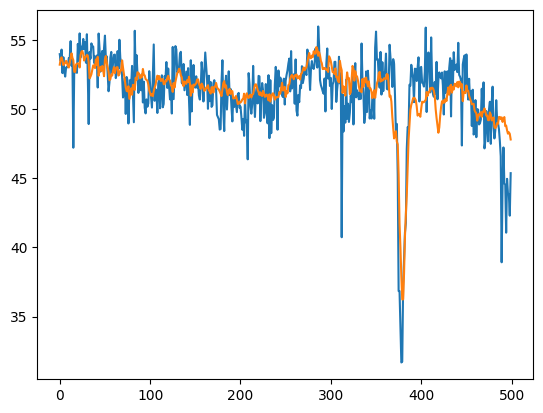

In [45]:
plt.plot(Y_train_ground_truth[0:500, 1, 0])
plt.plot(Y_preds[0:500, 1, 0])

In [46]:
Y_preds = get_predict_result(model=model, data_iter=test_iter, A_wave=A_wave, means=maxs, stds=mins)
np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

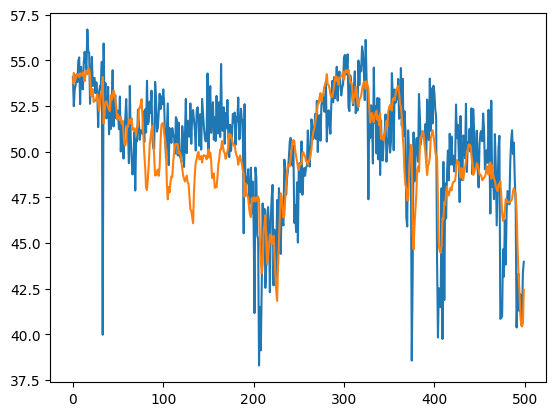

In [47]:
plt.plot(Y_test_ground_truth[0:500, 1, 0])
plt.plot(Y_preds[0:500, 1, 0])

#### microservices

default_data

In [108]:
def get_predict_result(model, data, A_wave, means, stds):
    with torch.no_grad():
        model.eval()
        data = data.to(device)
        Y_preds = model(A_wave, data).detach().cpu().numpy()
        Y_preds = denormalize_data(Y_preds, means[0].reshape([-1, 1]), stds[0].reshape([-1, 1]))
    return Y_preds

In [355]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
adj_type = "bad"
service = "no"
type_data = "calls"
feat_path = f"{data_path}/{service}_fault_{type_data}.npy"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

A_wave = get_normalized_adj(adj_matrix)
A_wave = torch.from_numpy(A_wave)
A_wave = A_wave.to(device=device)

model_type = "stgcn"
seq_len = 12
pre_len = 12
num_features = feat.shape[1]
num_nodes = feat.shape[2]

model_path = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"

In [356]:
train_data, test_data = train_test_split(data=feat)
maxs = feat.max(axis=0)
mins = feat.min(axis=0)

train_data_normalized = normalize_data(train_data, maxs, mins)
test_data_normalized = normalize_data(test_data, maxs, mins)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

X_train, _ = xy_split(train_data_normalized, seq_len, pre_len)
X_test, _ = xy_split(test_data_normalized, seq_len, pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [357]:
model = read_model(model_path=model_path, num_nodes=num_nodes, num_features=num_features, seq_len=seq_len, pre_len=pre_len)

In [358]:
save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}"

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [359]:
Y_preds = get_predict_result(model=model, data=X_train, A_wave=A_wave, means=maxs, stds=mins)
np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

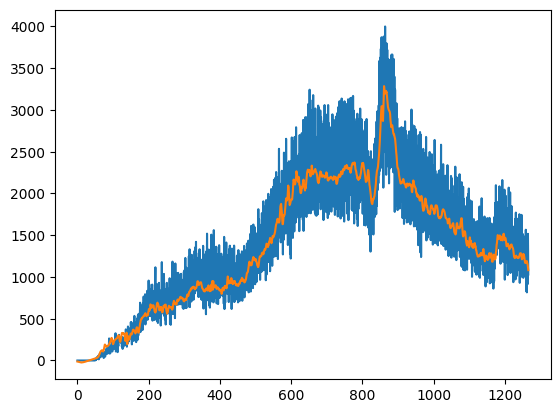

In [360]:
plt.plot(Y_train_ground_truth[:, 1, 0])
plt.plot(Y_preds[:, 1, 0])

In [361]:
Y_preds = get_predict_result(model=model, data=X_test, A_wave=A_wave, means=maxs, stds=mins)
np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

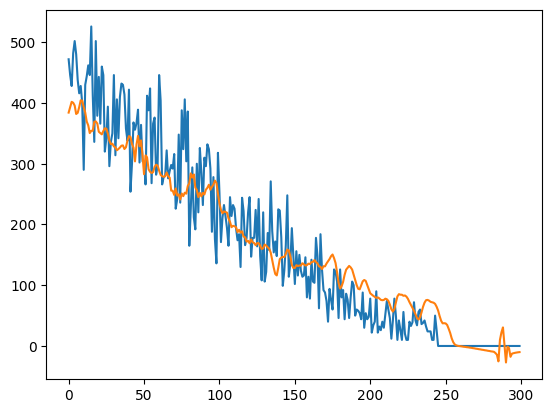

In [362]:
plt.plot(Y_test_ground_truth[:, 2, 0])
plt.plot(Y_preds[:, 2, 0])

fault data

In [363]:
for service in ("cart", "currency", "product"):
    feat_path = f"{data_path}/{service}_fault_{type_data}.npy"
    save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}"
    
    feat = load_features(feat_path)
    _, Y_ground_truth = xy_split(feat, seq_len, pre_len)
    # maxs = feat.max(axis=0)
    # mins = feat.min(axis=0)
    data_normalized = normalize_data(feat, maxs, mins)
    X_test, _ = xy_split(data_normalized, seq_len, pre_len)

    Y_preds = get_predict_result(
        model=model,
        data=X_test,
        A_wave=A_wave,
        means=maxs,
        stds=mins,
    )
    Y_preds = np.nan_to_num(Y_preds, 0)
    Y_preds = np.where(abs(Y_preds) > 10**10, 0, Y_preds) 
    np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply


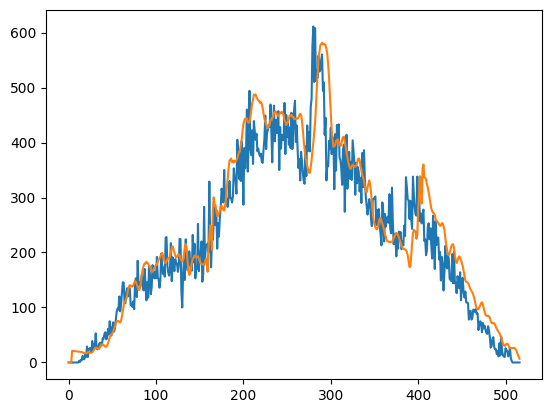

In [364]:
plt.plot(Y_ground_truth[:, 8, 0])
plt.plot(Y_preds[:, 8, 0])